In [21]:
from data_loader import dataloader
import os
import re
import pickle
import hashlib
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from os.path import isfile, isdir
from urllib.request import urlretrieve
from tensorflow.python.ops import math_ops
from sklearn.model_selection import train_test_split

In [22]:
tf.__version__

'2.8.0'

PREPROCESSING

In [23]:
user,ratings,movies = dataloader()
print(user.head())
print(movies.head())
print(ratings.head())

   user_id gender  age  occupation    zip
0        1      F    1          10  48067
1        2      M   56          16  70072
2        3      M   25          15  55117
3        4      M   45           7  02460
4        5      M   25          20  55455
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291


In [24]:
ratings = ratings.filter(regex=('user_id|movie_id|rating'))
print(ratings)

         user_id  movie_id  rating
0              1      1193       5
1              1       661       3
2              1       914       3
3              1      3408       4
4              1      2355       5
...          ...       ...     ...
1000204     6040      1091       1
1000205     6040      1094       5
1000206     6040       562       5
1000207     6040      1096       4
1000208     6040      1097       4

[1000209 rows x 3 columns]


In [25]:
n_users = len(ratings.user_id.unique())
n_movies = len(ratings.movie_id.unique())
print("No of unique users:", n_users)
print("No of unique movies: ", n_movies, "\n")

No of unique users: 6040
No of unique movies:  3706 



In [26]:
gender_map = {'F':0, 'M':1}
user['gender'] = user['gender'].map(gender_map)
age_map = {val:idx for idx, val in enumerate(set(user['age']))}
user['age'] = user['age'].map(age_map)
users = user.filter(regex='user_id|gender|age|occupation')
users['user_inf'] = users.apply(lambda x: list([x['gender'],
                                        x['age'],
                                        x['occupation']]),axis=1) 
user_map = {}
for i in range(len(users['user_id'])):
    k = {users.iloc[i]['user_id']: np.array(users.iloc[i]['user_inf'])}
    user_map.update(k)
user_map

{1: array([ 0,  0, 10], dtype=int64),
 2: array([ 1,  5, 16], dtype=int64),
 3: array([ 1,  6, 15], dtype=int64),
 4: array([1, 2, 7], dtype=int64),
 5: array([ 1,  6, 20], dtype=int64),
 6: array([0, 3, 9], dtype=int64),
 7: array([1, 1, 1], dtype=int64),
 8: array([ 1,  6, 12], dtype=int64),
 9: array([ 1,  6, 17], dtype=int64),
 10: array([0, 1, 1], dtype=int64),
 11: array([0, 6, 1], dtype=int64),
 12: array([ 1,  6, 12], dtype=int64),
 13: array([1, 2, 1], dtype=int64),
 14: array([1, 1, 0], dtype=int64),
 15: array([1, 6, 7], dtype=int64),
 16: array([0, 1, 0], dtype=int64),
 17: array([1, 3, 1], dtype=int64),
 18: array([0, 4, 3], dtype=int64),
 19: array([ 1,  0, 10], dtype=int64),
 20: array([ 1,  6, 14], dtype=int64),
 21: array([ 1,  4, 16], dtype=int64),
 22: array([ 1,  4, 15], dtype=int64),
 23: array([1, 1, 0], dtype=int64),
 24: array([0, 6, 7], dtype=int64),
 25: array([1, 4, 4], dtype=int64),
 26: array([1, 6, 7], dtype=int64),
 27: array([ 1,  6, 11], dtype=int64),
 

In [27]:
ratings['user_inf'] = ratings.loc[:, 'user_id']
ratings['user_inf'] = ratings['user_inf'].map(user_map)
ratings

,user_id,movie_id,rating,user_inf
0,1,1193,5,"[0, 0, 10]"
1,1,661,3,"[0, 0, 10]"
2,1,914,3,"[0, 0, 10]"
3,1,3408,4,"[0, 0, 10]"
4,1,2355,5,"[0, 0, 10]"
...,...,...,...,...
1000204,6040,1091,1,"[1, 6, 6]"
1000205,6040,1094,5,"[1, 6, 6]"
1000206,6040,562,5,"[1, 6, 6]"
1000207,6040,1096,4,"[1, 6, 6]"


In [28]:
genres_set = set()
for val in movies['genres'].str.split('|'):
    genres_set.update(val)
genres_set = list(genres_set)
genre_index_by_name = {name:i for i, name in enumerate(genres_set)}
print(genre_index_by_name)
# print(type(movie_index_by_id[1]))
movies_map = {}
movie_features = np.zeros((len(movies), len(genres_set)))
for i in range(len(movies)):
    for genre in movies.iloc[i]['genres'].split("|"):        
        genre_index = genre_index_by_name[genre]
        movie_features[i, genre_index] = 1
    k = {movies.iloc[i]['movie_id']: movie_features[i]}
    movies_map.update(k)
movies_map

{'Musical': 0, "Children's": 1, 'Comedy': 2, 'Documentary': 3, 'Sci-Fi': 4, 'Horror': 5, 'Thriller': 6, 'Drama': 7, 'Romance': 8, 'Mystery': 9, 'Film-Noir': 10, 'War': 11, 'Adventure': 12, 'Western': 13, 'Action': 14, 'Fantasy': 15, 'Animation': 16, 'Crime': 17}


{1: array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.]),
 2: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0.]),
 3: array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 4: array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 5: array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 6: array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1.]),
 7: array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 8: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.]),
 9: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.]),
 10: array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0.]),
 11: array([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0

In [29]:
ratings['movie_inf'] = ratings.loc[:, 'movie_id']
ratings['movie_inf'] = ratings['movie_inf'].map(movies_map)
ratings

,user_id,movie_id,rating,user_inf,movie_inf
0,1,1193,5,"[0, 0, 10]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
1,1,661,3,"[0, 0, 10]","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,914,3,"[0, 0, 10]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
3,1,3408,4,"[0, 0, 10]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,1,2355,5,"[0, 0, 10]","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
1000204,6040,1091,1,"[1, 6, 6]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1000205,6040,1094,5,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
1000206,6040,562,5,"[1, 6, 6]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
1000207,6040,1096,4,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


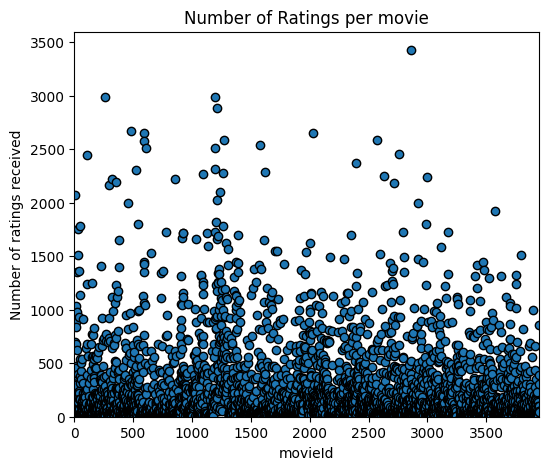

In [30]:
import matplotlib.pyplot as plt
rating_count = ratings[['movie_id','rating']].groupby(['movie_id']).count()
plt.figure(figsize=(6,5))
plt.scatter(rating_count.index, rating_count.rating, edgecolor='black')
plt.xlim(0,rating_count.index.max())
plt.ylim(0,)
plt.title('Number of Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

In [31]:
train, test = train_test_split(ratings, test_size= 0.2, random_state= 42)

NEURAL NETWORK BUILDING

In [40]:
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
import tensorflow as tf
     
#Creating movie embedding path
movie_input = Input(shape = (1,), name = "Movie-Input")
movie_embedding = Embedding(n_movies + 1, 10, name= "Movie-Embedding")(movie_input)
movie_vec = Flatten(name = "Flatten-Movies")(movie_embedding)

#Creating user embedding path
user_input = Input(shape = (1,), name = "User-Input")
user_embedding = Embedding(n_users + 1, 10, name = "User-Embedding")(user_input)
user_vec = Flatten(name = "Flatten-Users")(user_embedding)

#creating movie_inf embedding path
genres_input = Input(shape = (18,), name = "Genres-Input")
genres_embedding = Embedding(18, 5, name = "Genres-Embedding")(genres_input)
genres_vec = Flatten(name = "Flatten-Genres")(genres_embedding)


# Creating user_inf path
user_inf_input = Input(shape = (3,), name = "User_inf-Input")
# tf.convert_to_tensor(user_inf_input)
# user_inf_embedding = Embedding(n_users + 1, 10, name = "User_inf-Embedding")(user_inf_input)
user_inf_vec = Flatten(name = "Flatten_inf-Users")(user_inf_input)

#Concatenate features
conc = Concatenate()([movie_vec, user_vec, user_inf_vec, genres_vec])

#Weight Initialization
initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1., seed = None)

#Add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(100, activation='relu')(fc1)
fc3 = Dense(80, activation='relu')(fc2)
fc4 = Dense(60, activation='relu')(fc3)
fc5 = Dense(32, activation='relu')(fc4)
out = Dense(1)(fc5)

#Create model and compile it
model = Model([user_input, movie_input, user_inf_input,genres_input], out)
model.compile('adam', 'mean_squared_error')

In [41]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Movie-Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Genres-Input (InputLayer)      [(None, 18)]         0           []                               
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 10)        37070       ['Movie-Input[0][0]']            
                                                                                            

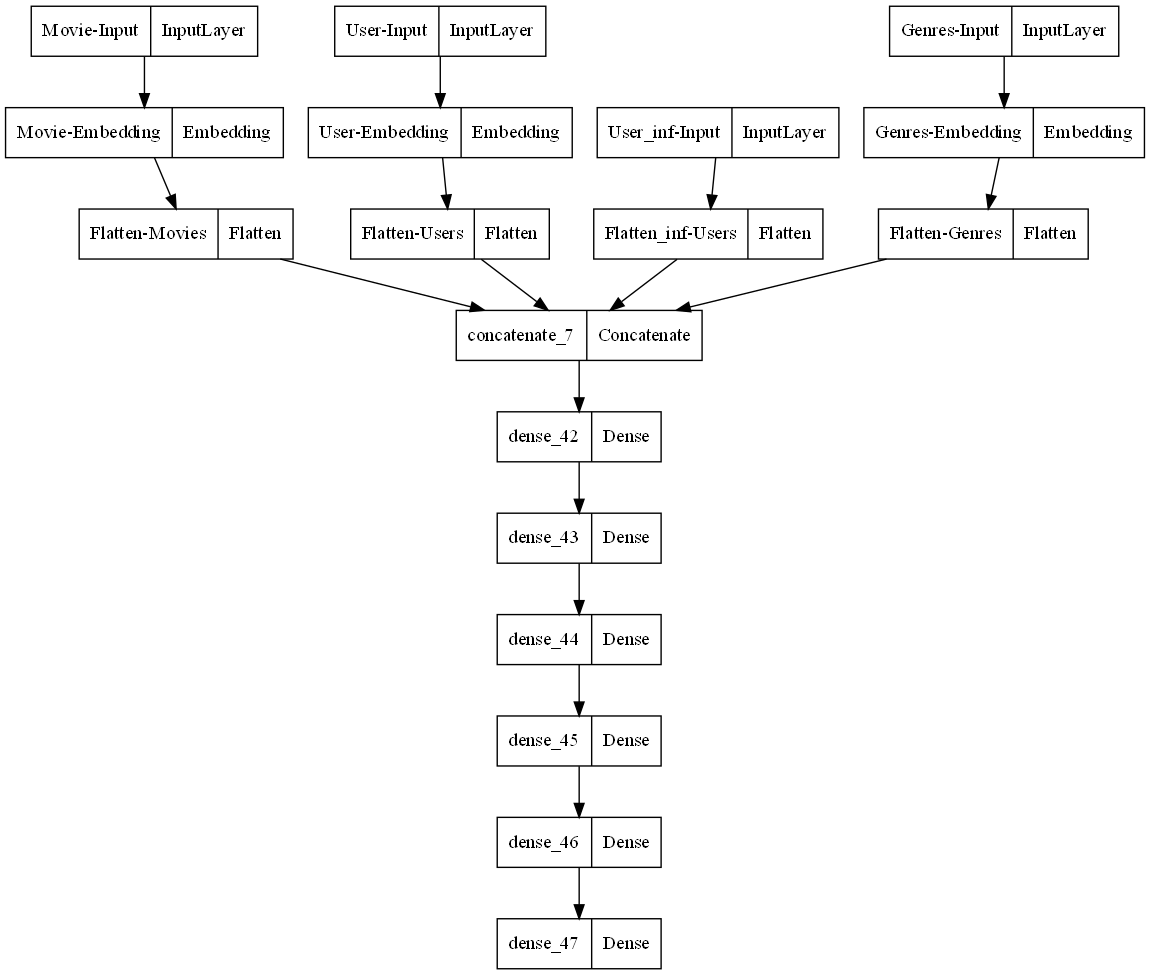

In [42]:
from keras.utils.vis_utils import plot_model
plot_model(model, rankdir= 'TR', dpi = 100)

In [ ]:
[print(i.shape, i.dtype) for i in model.inputs]

In [ ]:
train.user_inf

In [43]:
np.array([np.array(val) for val in train.user_inf]).shape
np.array([np.array(val) for val in train.movie_inf]).shape

(800167, 18)

In [ ]:
train.movie_id.shape

In [44]:
history = model.fit([train.user_id, train.movie_id,np.array([np.array(val) for val in train.user_inf]), np.array([np.array(val) for val in train.movie_inf])], train.rating, epochs = 18, verbose = 1)

Epoch 1/18
25006/25006 [==============================] - 177s 7ms/step - loss: 0.8923
Epoch 2/18
25006/25006 [==============================] - 182s 7ms/step - loss: 0.8197
Epoch 3/18
25006/25006 [==============================] - 176s 7ms/step - loss: 0.7962
Epoch 4/18
25006/25006 [==============================] - 175s 7ms/step - loss: 0.7761
Epoch 5/18
25006/25006 [==============================] - 177s 7ms/step - loss: 0.7580
Epoch 6/18
25006/25006 [==============================] - 175s 7ms/step - loss: 0.7451
Epoch 7/18
25006/25006 [==============================] - 172s 7ms/step - loss: 0.7321
Epoch 8/18
25006/25006 [==============================] - 174s 7ms/step - loss: 0.7201
Epoch 9/18
25006/25006 [==============================] - 175s 7ms/step - loss: 0.7103
Epoch 10/18
25006/25006 [==============================] - 176s 7ms/step - loss: 0.7021
Epoch 11/18
25006/25006 [==============================] - 176s 7ms/step - loss: 0.6948
Epoch 12/18
25006/25006 [================

In [45]:
model.evaluate([test.user_id, test.movie_id, np.array([np.array(val) for val in test.user_inf]), np.array([np.array(val) for val in test.movie_inf]) ], test.rating)

6252/6252 [==============================] - 20s 3ms/step - loss: 0.7650


0.765009880065918